<a href="https://colab.research.google.com/github/SwethaRavikumar/College/blob/main/fuzzy_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fuzzy import *
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

## FUZZY CLASSIFICATION ON IRIS DATASET

In [ ]:
class FuzzyClassifier:

	def __init__(self, sensitivity=1, exp_bound=1):

		self.sensitivity = sensitivity
		self.hyperboxes = None
		self.classes = np.array([])
		self.exp_bound = exp_bound


	def membership(self, pattern):
		min_pts = self.hyperboxes[:, 0, :]
		max_pts = self.hyperboxes[:, 1, :]
		
		a = np.maximum(0, (1 - np.maximum(0, (self.sensitivity * np.minimum(1, pattern - max_pts)))))
		b = np.maximum(0, (1 - np.maximum(0, (self.sensitivity * np.minimum(1, min_pts - pattern)))))

		return np.sum(a + b, axis=1) / (2 * len(pattern))


	def overlap_contract(self, index):
		contracted = False
		for test_box in range(len(self.hyperboxes)):

			if self.classes[test_box] == self.classes[index]:
				# Ignore same class hyperbox overlap
				continue
	
			expanded_box = self.hyperboxes[index]
			box = self.hyperboxes[test_box]

			## TODO: Refactor for vectorization
			vj, wj = expanded_box
			vk, wk = box

			delta_new = delta_old = 1
			min_overlap_index = -1
			for i in range(len(vj)):
				if vj[i] < vk[i] < wj[i] < wk[i]:
					delta_new = min(delta_old, wj[i] - vk[i])

				elif vk[i] < vj[i] < wk[i] < wj[i]:
					delta_new = min(delta_old, wk[i] - vj[i])

				elif vj[i] < vk[i] < wk[i] < wj[i]:
					delta_new = min(delta_old, min(wj[i] - vk[i], wk[i] - vj[i]))

				elif vk[i] < vj[i] < wj[i] < wk[i]:
					delta_new = min(delta_old, min(wj[i] - vk[i], wk[i] - vj[i]))

				if delta_old - delta_new > 0:
					min_overlap_index = i
					delta_old = delta_new

			if min_overlap_index >= 0:
				i = min_overlap_index
				# We need to contract the expanded box
				if vj[i] < vk[i] < wj[i] < wk[i]:
					vk[i] = wj[i] = (vk[i] + wj[i])/2

				elif vk[i] < vj[i] < wk[i] < wj[i]:
					vj[i] = wk[i] = (vj[i] + wk[i])/2

				elif vj[i] < vk[i] < wk[i] < wj[i]:
					if (wj[i] - vk[i]) > (wk[i] - vj[i]):
						vj[i] = wk[i]

					else:
						wj[i] = vk[i]

				elif vk[i] < vj[i] < wj[i] < wk[i]:
					if (wk[i] - vj[i]) > (wj[i] - vk[i]):
						vk[i] = wj[i]

					else:
						wk[i] = vj[i]

				self.hyperboxes[test_box] = np.array([vk, wk])
				self.hyperboxes[index] = np.array([vj, wj])
				contracted = True

		return contracted



	def train_pattern(self, X, Y):
		target = Y
		
		if target not in self.classes:
			
			
			if self.hyperboxes is not None:
				self.hyperboxes = np.vstack((self.hyperboxes, np.array([[X, X]])))
				self.classes = np.hstack((self.classes, np.array([target])))

			else:
				self.hyperboxes = np.array([[X, X]])
				self.classes = np.array([target])

		else:
			
			memberships = self.membership(X)
			memberships[np.where(self.classes != target)] = 0
			memberships = sorted(list(enumerate(memberships)), key=lambda x: x[1], reverse=True)
			
			count = 0
			while True:
				index = memberships[count][0]
				min_new = np.minimum(self.hyperboxes[index, 0, :], X)
				max_new = np.maximum(self.hyperboxes[index, 1, :], X)
				
				if self.exp_bound * len(np.unique(self.classes)) >= np.sum(max_new - min_new):
					self.hyperboxes[index, 0] = min_new
					self.hyperboxes[index, 1] = max_new
					break
				else:
					count += 1

				if count == len(memberships):
					self.hyperboxes = np.vstack((self.hyperboxes, np.array([[X, X]])))
					self.classes = np.hstack((self.classes, np.array([target])))
					index = len(self.hyperboxes) - 1
					break

			contracted = self.overlap_contract(index)


	def fit(self, X, Y):
		for x, y in zip(X, Y):
			self.train_pattern(x, y)


	def predict(self, X):
		classes = np.unique(self.classes)
		results = []
		memberships = self.membership(X)
		max_prediction = 0
		pred_class = 0
		for _class in classes:
			mask = np.zeros((len(self.hyperboxes),))
			mask[np.where(self.classes == _class)] = 1
			p = memberships * mask
			prediction, class_index = np.max(p), np.argmax(p)
			if prediction > max_prediction:
				max_prediction = prediction
				pred_class = class_index

		return max_prediction, self.classes[pred_class] 


	def score(self, X, Y):
		count = 0
		for x, y in zip(X, Y):
			_, pred = self.predict(x)
			if y == pred:
				count += 1

		return count / len(Y)

In [ ]:
data_set = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SOFT COMPUTING/fuzzy-min-max-classifier-master/iris.data', header=None, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])

data_set = data_set[~(data_set['class']=='Iris-virginica')]

data_set.head()

data_set.replace(to_replace='Iris-setosa', value=0, inplace=True)

data_set.replace(to_replace='Iris-versicolor', value=1, inplace=True)

data_set = data_set.sample(frac=1)

X_Train = data_set[['sepal length', 'sepal width']].values
Y_Train = data_set['class'].values

maximum_ = np.max(X_Train, axis=0)
minimum_ = np.min(X_Train, axis=0)
X_Train = (X_Train - minimum_) / (maximum_ - minimum_)

X_test, Y_test = X_Train[-20:], Y_Train[-20:]
X_Train, Y_Train = X_Train[:-20], Y_Train[:-20]

In [ ]:
X_Train.shape, Y_Train.shape

((80, 2), (80,))

In [ ]:
clf2 = FuzzyClassifier(sensitivity=1, exp_bound=0.1)  

#Fuzzy Classifier class imported from fuzzy.

In [ ]:
clf2.fit(X_Train, Y_Train)

In [ ]:
clf2.score(X_test,Y_test)

0.95

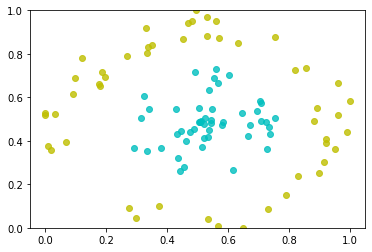

In [ ]:
for x, y in zip(train_x, train_y):
    if y == 0:
        plt.scatter(x[0], x[1], c='c', alpha=0.8)
    else:
        plt.scatter(x[0], x[1], c='y', alpha=0.8)
plt.ylim([0, 1])
plt.show()